# **Notebook 2b**: Sign Shape Type

<span style="font-size: 1.5rem;">By **Melat Assefa**</span>

# Imports and Setup

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision.transforms.functional import to_tensor
import json
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import time
import random
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter
from pycocotools.coco import COCO
from collections import defaultdict
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

# Section 0: Notebook Metadata and Configuration

In [2]:
# set seed for reproducibility
SEED = 3129
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
# notebook metadata
COURSE = "ARI3129"
TASK = "Task 2b - Attribute Classification"
STUDENT = "Alison Attard"
DETECTOR_NAME = "centernet"
ATTRIBUTE_FOCUS = "sign_shape"
FRAMEWORK = "PyTorch"

# dataset paths
repo_root = Path.cwd()
dataset_root = repo_root / "dataset"
work_dir = repo_root / "work_dirs" / f"{DETECTOR_NAME}_{ATTRIBUTE_FOCUS}"

# annotations for sign shape attribute
annotations_dir = dataset_root / "COCO-based_COCO_sign_shape" / "annotations"
train_annot = annotations_dir / "train.json"
val_annot = annotations_dir / "val.json"
test_annot = annotations_dir / "test.json"

# images directory
images_base = dataset_root / "COCO-based_COCO" / "images"
train_imgs = images_base / "train"
val_imgs = images_base / "val"
test_imgs = images_base / "test"

# output directories
checkpoint_dir = work_dir / "checkpoints"
tensorboard_dir = work_dir / "logs"
results_dir = work_dir / "results"

checkpoint_dir.mkdir(parents=True, exist_ok=True)
tensorboard_dir.mkdir(parents=True, exist_ok=True)
results_dir.mkdir(parents=True, exist_ok=True)

# training configuration
NUM_EPOCHS = 12
BATCH_SIZE = 8
LEARNING_RATE = 0.0001
INPUT_SIZE = 512
NUM_CLASSES = 5  # Circle, Square, Triangle, Octagonal, Damaged
TIMESTAMP = datetime.now().strftime("%Y%m%d_%H%M%S")

# class names for sign shapes
CLASS_NAMES = [
    'Circle',
    'Damaged',
    'Octagonal',
    'Square',
    'Triangle'
]

# Section 1: Environment Setup

In [4]:
print("notebook metadata and configuration")
print(f"course: {COURSE}")
print(f"task: {TASK}")
print(f"student: {STUDENT}")
print(f"detector: {DETECTOR_NAME}")
print(f"attribute: {ATTRIBUTE_FOCUS}")
print(f"framework: {FRAMEWORK}")
print(f"seed: {SEED}")
print()

print("pytorch environment")
print(f"pytorch version: {torch.__version__}")
print(f"cuda available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"gpu name: {torch.cuda.get_device_name(0)}")
    print(f"gpu memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} gb")
print()

print("model configuration")
print(f"input size: {INPUT_SIZE}")
print(f"num classes: {NUM_CLASSES}")
print(f"batch size: {BATCH_SIZE}")
print(f"epochs: {NUM_EPOCHS}")
print(f"learning rate: {LEARNING_RATE}")
print()

notebook metadata and configuration
course: ARI3129
task: Task 2b - Attribute Classification
student: Alison Attard
detector: centernet
attribute: sign_shape
framework: PyTorch
seed: 3129

pytorch environment
pytorch version: 2.9.0
cuda available: False

model configuration
input size: 512
num classes: 5
batch size: 8
epochs: 12
learning rate: 0.0001



In [5]:
# set device and tensorboard writer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
writer = SummaryWriter(log_dir=str(tensorboard_dir))
print(f"device: {device}")

device: cpu


# Section 2: Dataset Validation

In [6]:
print("dataset validation")
print()

if train_annot.exists():
    print(f"train json found")
else:
    print(f"warning: train json not found at {train_annot}")

if val_annot.exists():
    print(f"val json found")
else:
    print(f"warning: val json not found at {val_annot}")

if test_annot.exists():
    print(f"test json found")
else:
    print(f"warning: test json not found at {test_annot}")

if train_imgs.exists():
    print(f"train images found")
else:
    print(f"warning: train images not found")

if val_imgs.exists():
    print(f"val images found")
else:
    print(f"warning: val images not found")

if test_imgs.exists():
    print(f"test images found")
else:
    print(f"warning: test images not found")

print()

dataset validation

train json found
val json found
test json found
train images found
val images found
test images found



In [7]:
# load coco annotations
coco_train = None
coco_val = None
coco_test = None

try:
    coco_train = COCO(str(train_annot))
    train_img_count = len(coco_train.imgs)
    train_ann_count = len(coco_train.anns)
    print(f"train dataset loaded: {train_img_count} images, {train_ann_count} annotations")
except Exception as e:
    print(f"error loading train dataset: {e}")

try:
    coco_val = COCO(str(val_annot))
    val_img_count = len(coco_val.imgs)
    val_ann_count = len(coco_val.anns)
    print(f"val dataset loaded: {val_img_count} images, {val_ann_count} annotations")
except Exception as e:
    print(f"error loading val dataset: {e}")

try:
    coco_test = COCO(str(test_annot))
    test_img_count = len(coco_test.imgs)
    test_ann_count = len(coco_test.anns)
    print(f"test dataset loaded: {test_img_count} images, {test_ann_count} annotations")
except Exception as e:
    print(f"error loading test dataset: {e}")

print()

if coco_train is not None:
    try:
        cats = coco_train.loadCats(coco_train.getCatIds())
        cat_names = [cat['name'] for cat in cats]
        print(f"class names from dataset: {cat_names}")
        print(f"number of classes: {len(cat_names)}")
    except Exception as e:
        print(f"could not load class names: {e}")

print()

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
train dataset loaded: 483 images, 527 annotations
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
val dataset loaded: 88 images, 92 annotations
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
test dataset loaded: 86 images, 93 annotations

class names from dataset: ['Circular', 'Damaged', 'Octagonal', 'Square', 'Triangular']
number of classes: 5



# Section 3: Dataset and Model Definition

In [8]:
from PIL import Image, ImageOps

class COCODataset(Dataset):
    """custom coco dataset for attribute classification"""
    def __init__(self, coco, image_dir, transform=None, input_size=512):
        self.coco = coco
        self.image_dir = Path(image_dir) if not isinstance(image_dir, Path) else image_dir
        self.transform = transform
        self.image_ids = list(coco.imgs.keys())
        self.input_size = input_size
    
    def __len__(self):
        return len(self.image_ids)
    
    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        img_data = self.coco.imgs[img_id]
        img_path = self.image_dir / img_data['file_name']
        
        try:
            image = Image.open(str(img_path)).convert('RGB')
            image = ImageOps.exif_transpose(image)
        except Exception as e:
            image = Image.new('RGB', (self.input_size, self.input_size))
        
        original_height, original_width = image.size[::-1]
        image = image.resize((self.input_size, self.input_size), Image.Resampling.BILINEAR)
        
        # load annotations for this image
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        annotations = self.coco.loadAnns(ann_ids)
        
        # extract attribute label from annotation
        if len(annotations) > 0:
            label = annotations[0].get('category_id', 0) - 1
        else:
            label = 0
        
        # apply transforms
        if self.transform:
            image = self.transform(image)
        else:
            image = to_tensor(image)
        
        return image, label, img_id

In [9]:
class CenterNetShapeClassifier(nn.Module):
    """centernet based classifier for traffic sign shapes"""
    def __init__(self, num_classes=5):
        super(CenterNetShapeClassifier, self).__init__()
        self.num_classes = num_classes
        
        # backbone: convolutional feature extraction
        self.backbone = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        )
        
        # global average pooling
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        # classifier head
        self.classifier = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )
    
    def forward(self, x):
        features = self.backbone(x)
        features = self.global_avg_pool(features)
        features = features.view(features.size(0), -1)
        class_logits = self.classifier(features)
        return class_logits

# Section 4: Data Preparation and Model Setup

In [10]:
# create data transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# initialize datasets
if coco_train is not None and coco_val is not None and coco_test is not None:
    train_dataset = COCODataset(coco_train, train_imgs, transform=transform, input_size=INPUT_SIZE)
    val_dataset = COCODataset(coco_val, val_imgs, transform=transform, input_size=INPUT_SIZE)
    test_dataset = COCODataset(coco_test, test_imgs, transform=transform, input_size=INPUT_SIZE)
    
    # create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
    
    print(f"train samples: {len(train_dataset)}")
    print(f"val samples: {len(val_dataset)}")
    print(f"test samples: {len(test_dataset)}")
    print()
else:
    print("error: datasets not loaded")

train samples: 483
val samples: 88
test samples: 86



## Visualisation

visualizing 3 sample images from train set with annotations



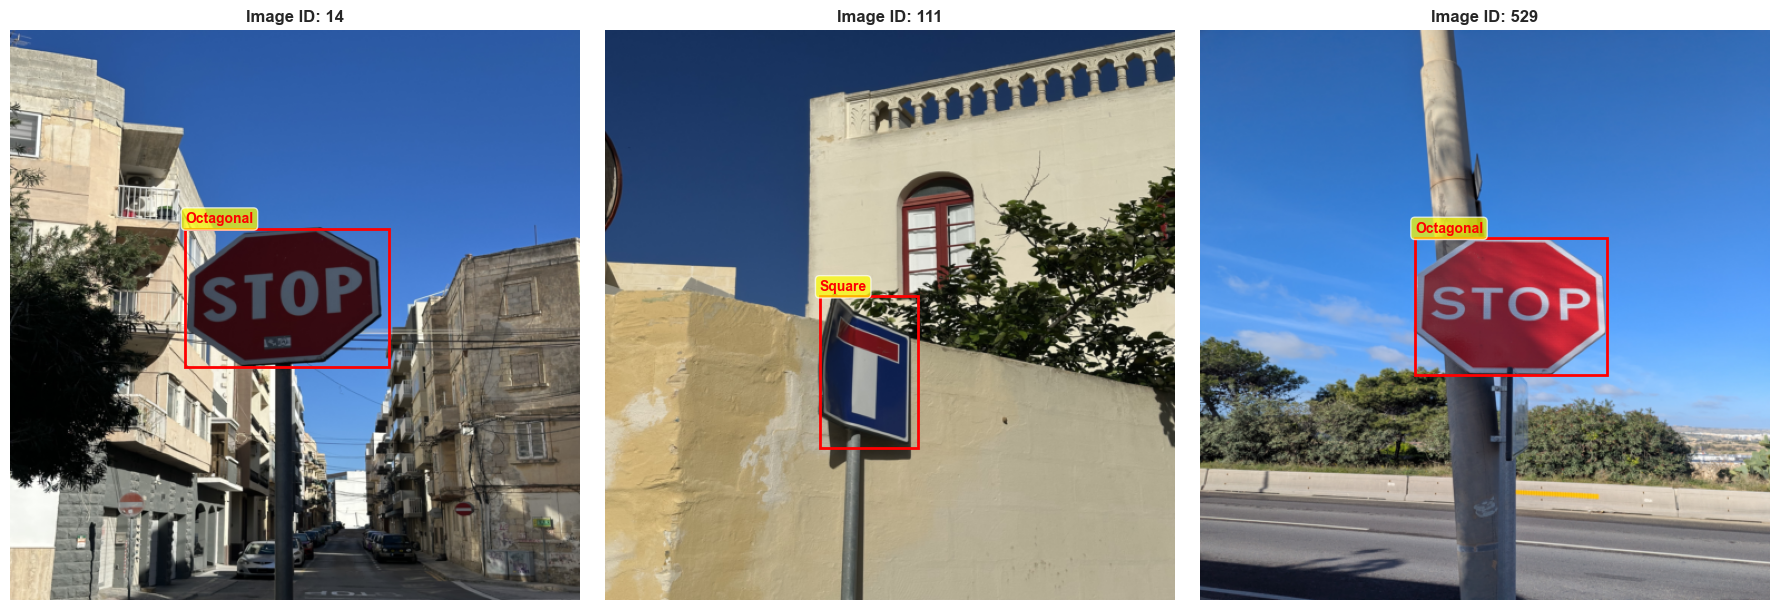

sample train images with bounding boxes displayed and saved



In [25]:
print("visualizing 3 sample images from train set with annotations")
print()

# randomly select 3 image indices
sample_indices = np.random.choice(len(train_dataset), size=3, replace=False)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
sns.set_style("white")

for plot_idx, sample_idx in enumerate(sample_indices):
    # get image data
    image, label, img_id = train_dataset[sample_idx]
    
    # denormalize for visualization
    image_np = image.permute(1, 2, 0).cpu().numpy()
    image_np = image_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    image_np = np.clip(image_np, 0, 1)
    
    # get original image from file
    img_data = coco_train.imgs[img_id]
    img_path = train_imgs / img_data['file_name']
    original_image = Image.open(str(img_path)).convert('RGB')
    original_image = ImageOps.exif_transpose(original_image)
    original_image_resized = original_image.resize((INPUT_SIZE, INPUT_SIZE), Image.Resampling.BILINEAR)
    
    # convert to numpy
    original_np = np.array(original_image_resized) / 255.0
    
    # get annotations
    ann_ids = coco_train.getAnnIds(imgIds=img_id)
    annotations = coco_train.loadAnns(ann_ids)
    
    # display image
    axes[plot_idx].imshow(original_np)
    axes[plot_idx].set_title(f'Image ID: {img_id}', fontsize=12, fontweight='bold')
    axes[plot_idx].axis('off')
    
    # draw bounding boxes
    for ann in annotations:
        bbox = ann['bbox']
        x, y, w, h = bbox
        
        # scale bbox to resized image dimensions
        scale_x = INPUT_SIZE / original_image.width
        scale_y = INPUT_SIZE / original_image.height
        
        x_scaled = x * scale_x
        y_scaled = y * scale_y
        w_scaled = w * scale_x
        h_scaled = h * scale_y
        
        # draw rectangle
        rect = plt.Rectangle((x_scaled, y_scaled), w_scaled, h_scaled, 
                             linewidth=2, edgecolor='red', facecolor='none')
        axes[plot_idx].add_patch(rect)
        
        # get class name
        cat_id = ann['category_id']
        cat_name = coco_train.loadCats(cat_id)[0]['name']
        
        # add text label
        axes[plot_idx].text(x_scaled, y_scaled - 5, cat_name, 
                           fontsize=10, color='red', fontweight='bold',
                           bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))

plt.tight_layout()
plt.savefig(str(work_dir / 'sample_train_images.png'), dpi=300, bbox_inches='tight')
plt.show()

print("sample train images with bounding boxes displayed and saved")
print()

In [11]:
# initialize model
model = CenterNetShapeClassifier(num_classes=NUM_CLASSES)
model = model.to(device)

print(f"model initialized for sign shape classification")
print(f"num classes: {NUM_CLASSES}")
print(f"input size: {INPUT_SIZE}")
print(f"total parameters: {sum(p.numel() for p in model.parameters()):,}")
print()

model initialized for sign shape classification
num classes: 5
input size: 512
total parameters: 412,933



## CenterNet Architecture Rationale

CenterNet is selected for efficient attribute classification of traffic sign shapes. The backbone progressively extracts features through downsampling layers with batch normalization and ReLU activations. The global average pooling converts spatial features to a compact representation, which feeds into the classifier head for predicting sign shape. This architecture is lightweight, computationally efficient, and suitable for real-time traffic monitoring applications.

In [12]:
# setup optimizer, loss, and scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

print(f"optimizer: adam")
print(f"learning rate: {LEARNING_RATE}")
print(f"loss function: cross entropy loss")
print(f"scheduler: steplr, step size 5, gamma 0.5")
print()

print(f"tensorboard command: tensorboard --logdir {tensorboard_dir}")
print()

optimizer: adam
learning rate: 0.0001
loss function: cross entropy loss
scheduler: steplr, step size 5, gamma 0.5

tensorboard command: tensorboard --logdir /Users/alisonattard/Documents/Uni/Yr 3/ARI3129 AdvancedCV/ARI3129/work_dirs/centernet_sign_shape/logs



# Section 5: Training

In [13]:
print("training started")
print()

training_losses = []
validation_accuracies = []
best_accuracy = 0.0
best_epoch = 0
training_start_time = time.time()

for epoch in range(NUM_EPOCHS):
    epoch_start = time.time()
    model.train()
    epoch_loss = 0.0
    batch_count = 0
    
    # training loop
    for batch_idx, (images, labels, img_ids) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        class_logits = model(images)
        
        loss = criterion(class_logits, labels)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        batch_count += 1
        
        # periodic loss reporting
        if batch_idx % max(1, len(train_loader) // 5) == 0:
            print(f"epoch {epoch + 1}/{NUM_EPOCHS}, batch {batch_idx}/{len(train_loader)}, loss: {loss.item():.6f}")
    
    avg_epoch_loss = epoch_loss / max(batch_count, 1)
    training_losses.append(avg_epoch_loss)
    
    # validation loop
    model.eval()
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for images, labels, img_ids in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            class_logits = model(images)
            
            predictions = torch.argmax(class_logits, dim=1)
            val_correct += (predictions == labels).sum().item()
            val_total += labels.size(0)
    
    val_accuracy = val_correct / max(val_total, 1)
    validation_accuracies.append(val_accuracy)
    
    scheduler.step()
    
    epoch_time = time.time() - epoch_start
    
    # tensorboard logging
    writer.add_scalar('train/loss', avg_epoch_loss, epoch)
    writer.add_scalar('val/accuracy', val_accuracy, epoch)
    
    print(f"epoch {epoch + 1} summary: train loss {avg_epoch_loss:.6f}, val accuracy {val_accuracy:.4f}, time {epoch_time:.2f}s")
    
    # save best checkpoint
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_epoch = epoch
        checkpoint_path = checkpoint_dir / f"best_epoch_{epoch + 1}.pt"
        torch.save(model.state_dict(), str(checkpoint_path))
        print(f"best checkpoint saved to {checkpoint_path}")
    
    # save last checkpoint
    if epoch == NUM_EPOCHS - 1:
        checkpoint_path = checkpoint_dir / "last_epoch.pt"
        torch.save(model.state_dict(), str(checkpoint_path))
        print(f"last checkpoint saved to {checkpoint_path}")

total_training_time = time.time() - training_start_time
print()
print(f"training completed in {total_training_time:.2f} seconds")
print()

training started

epoch 1/12, batch 0/61, loss: 1.664034
epoch 1/12, batch 12/61, loss: 1.320983
epoch 1/12, batch 24/61, loss: 1.137201
epoch 1/12, batch 36/61, loss: 1.529990
epoch 1/12, batch 48/61, loss: 1.419970
epoch 1/12, batch 60/61, loss: 1.928916
epoch 1 summary: train loss 1.337640, val accuracy 0.5341, time 60.13s
best checkpoint saved to /Users/alisonattard/Documents/Uni/Yr 3/ARI3129 AdvancedCV/ARI3129/work_dirs/centernet_sign_shape/checkpoints/best_epoch_1.pt
epoch 2/12, batch 0/61, loss: 1.266435
epoch 2/12, batch 12/61, loss: 1.224495
epoch 2/12, batch 24/61, loss: 1.186164
epoch 2/12, batch 36/61, loss: 0.924440
epoch 2/12, batch 48/61, loss: 1.185153
epoch 2/12, batch 60/61, loss: 1.722625
epoch 2 summary: train loss 1.192163, val accuracy 0.5682, time 59.64s
best checkpoint saved to /Users/alisonattard/Documents/Uni/Yr 3/ARI3129 AdvancedCV/ARI3129/work_dirs/centernet_sign_shape/checkpoints/best_epoch_2.pt
epoch 3/12, batch 0/61, loss: 1.093944
epoch 3/12, batch 12/61

# Section 6: Test Set Evaluation

In [14]:
print("test set evaluation")
print()

# load best checkpoint
model.load_state_dict(torch.load(str(checkpoint_dir / f"best_epoch_{best_epoch + 1}.pt")))
model.eval()

test_correct = 0
test_total = 0
per_class_correct = defaultdict(int)
per_class_total = defaultdict(int)

# evaluate on test set
with torch.no_grad():
    for images, labels, img_ids in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        class_logits = model(images)
        predictions = torch.argmax(class_logits, dim=1)
        
        test_correct += (predictions == labels).sum().item()
        test_total += labels.size(0)
        
        # per-class accuracy
        for pred, label in zip(predictions.cpu().numpy(), labels.cpu().numpy()):
            per_class_total[label] += 1
            if pred == label:
                per_class_correct[label] += 1

overall_accuracy = test_correct / max(test_total, 1)
print(f"overall test accuracy: {overall_accuracy:.4f}")
print()

test set evaluation

overall test accuracy: 0.5930



In [15]:
# per-class accuracy table
print("per-class accuracy")
print()

class_accuracies = []
class_data = []

for class_idx in range(NUM_CLASSES):
    if per_class_total[class_idx] > 0:
        acc = per_class_correct[class_idx] / per_class_total[class_idx]
        class_accuracies.append(acc)
        class_data.append({
            'Class': CLASS_NAMES[class_idx],
            'Correct': per_class_correct[class_idx],
            'Total': per_class_total[class_idx],
            'Accuracy': f'{acc:.4f}'
        })
    else:
        class_accuracies.append(0.0)

class_df = pd.DataFrame(class_data)
print(class_df.to_string(index=False))
print()

per-class accuracy

    Class  Correct  Total Accuracy
   Circle       45     50   0.9000
Octagonal        0     15   0.0000
   Square        6     18   0.3333
 Triangle        0      3   0.0000



# Section 7: Training Curves and Monitoring

training curves and monitoring



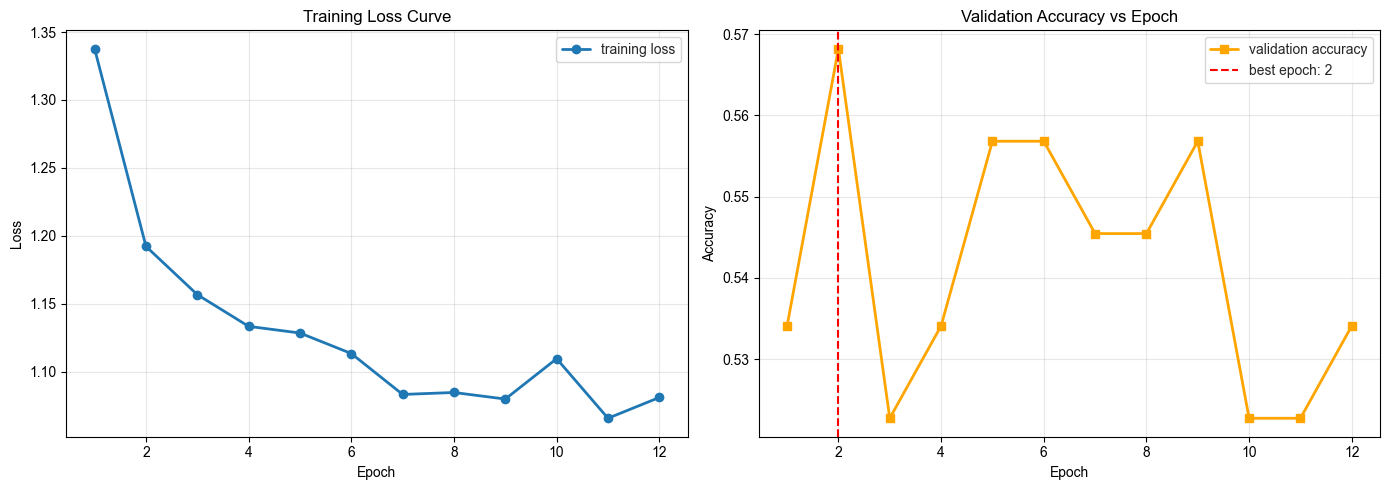

training curves plotted and saved



In [16]:
print("training curves and monitoring")
print()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.set_style("whitegrid")
axes[0].plot(range(1, len(training_losses) + 1), training_losses, marker='o', label='training loss', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training Loss Curve')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(range(1, len(validation_accuracies) + 1), validation_accuracies, marker='s', label='validation accuracy', color='orange', linewidth=2)
axes[1].axvline(x=best_epoch + 1, color='red', linestyle='--', label=f'best epoch: {best_epoch + 1}')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Validation Accuracy vs Epoch')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(str(work_dir / 'training_curves.png'), dpi=300, bbox_inches='tight')
plt.show()

print("training curves plotted and saved")
print()

# Section 8: Per-Class Accuracy Bar Chart

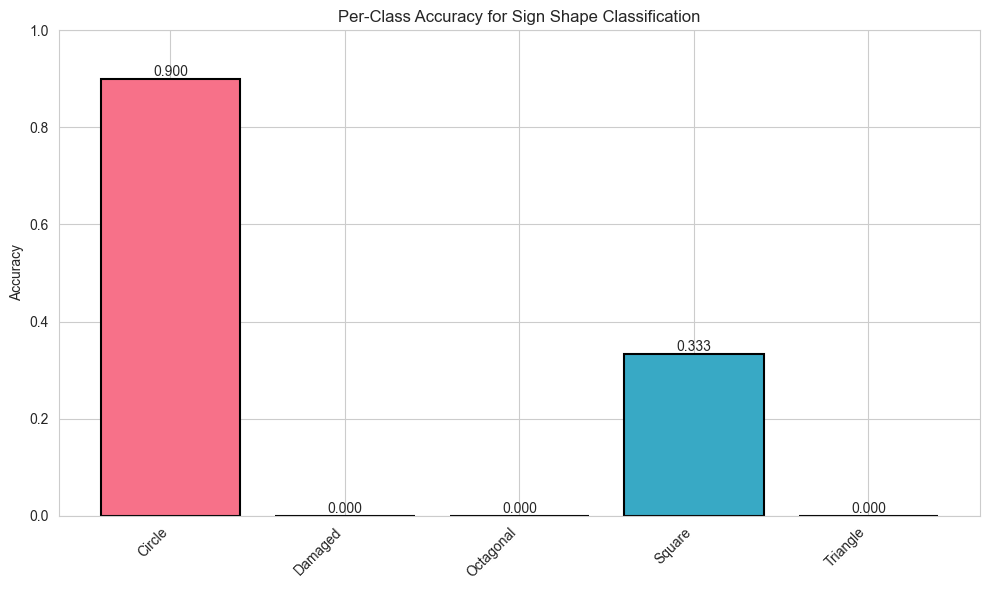

per-class accuracy bar chart plotted and saved



In [17]:
# plot per-class accuracy
if NUM_CLASSES >= 3:
    fig, ax = plt.subplots(figsize=(10, 6))
    
    sns.set_style("whitegrid")
    class_names_list = [CLASS_NAMES[i] for i in range(NUM_CLASSES)]
    
    colors = sns.color_palette("husl", NUM_CLASSES)
    bars = ax.bar(class_names_list, class_accuracies, color=colors, edgecolor='black', linewidth=1.5)
    
    ax.set_ylabel('Accuracy')
    ax.set_title('Per-Class Accuracy for Sign Shape Classification')
    ax.set_ylim([0, 1.0])
    
    # add value labels on bars
    for bar, acc in zip(bars, class_accuracies):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{acc:.3f}', ha='center', va='bottom', fontsize=10)
    
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig(str(work_dir / 'per_class_accuracy.png'), dpi=300, bbox_inches='tight')
    plt.show()
    
    print("per-class accuracy bar chart plotted and saved")
print()

# Section 9: Qualitative Results and Failure Analysis

In [18]:
# select subset of test images for qualitative analysis
print("qualitative results and failure analysis")
print()

model.eval()
test_results = []

with torch.no_grad():
    for batch_idx, (images, labels, img_ids) in enumerate(test_loader):
        images = images.to(device)
        class_logits = model(images)
        predictions = torch.argmax(class_logits, dim=1)
        confidences = torch.nn.functional.softmax(class_logits, dim=1)
        max_confidence = torch.max(confidences, dim=1)[0]
        
        for i in range(len(predictions)):
            pred = predictions[i].item()
            label = labels[i].item()
            confidence = max_confidence[i].item()
            img_id = img_ids[i]
            
            test_results.append({
                'img_id': img_id,
                'true_class': CLASS_NAMES[label],
                'pred_class': CLASS_NAMES[pred],
                'confidence': confidence,
                'correct': pred == label
            })

results_df = pd.DataFrame(test_results)
print(f"total test samples analyzed: {len(results_df)}")
print(f"correct predictions: {results_df['correct'].sum()}")
print(f"incorrect predictions: {(~results_df['correct']).sum()}")
print()

# show sample of correct predictions
print("sample correct predictions:")
correct_samples = results_df[results_df['correct']].head(5)
print(correct_samples[['true_class', 'pred_class', 'confidence']].to_string(index=False))
print()

# show sample of incorrect predictions
print("sample incorrect predictions:")
incorrect_samples = results_df[~results_df['correct']].head(5)
print(incorrect_samples[['true_class', 'pred_class', 'confidence']].to_string(index=False))
print()

qualitative results and failure analysis

total test samples analyzed: 86
correct predictions: 51
incorrect predictions: 35

sample correct predictions:
true_class pred_class  confidence
    Circle     Circle    0.484432
    Circle     Circle    0.393547
    Circle     Circle    0.375316
    Circle     Circle    0.542530
    Circle     Circle    0.559947

sample incorrect predictions:
true_class pred_class  confidence
 Octagonal     Circle    0.451282
 Octagonal     Circle    0.319537
 Octagonal     Circle    0.434584
    Circle     Square    0.292582
 Octagonal     Circle    0.373927



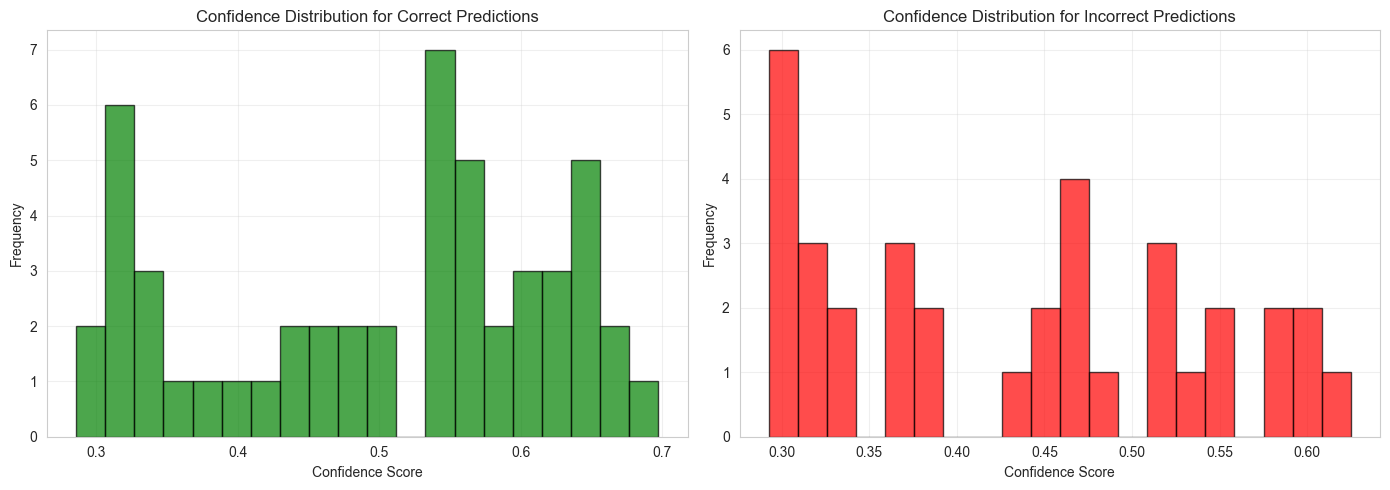

confidence distributions plotted and saved



In [19]:
# confidence score histogram
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.set_style("whitegrid")
correct_conf = results_df[results_df['correct']]['confidence']
incorrect_conf = results_df[~results_df['correct']]['confidence']

axes[0].hist(correct_conf, bins=20, color='green', alpha=0.7, edgecolor='black')
axes[0].set_xlabel('Confidence Score')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Confidence Distribution for Correct Predictions')
axes[0].grid(True, alpha=0.3)

axes[1].hist(incorrect_conf, bins=20, color='red', alpha=0.7, edgecolor='black')
axes[1].set_xlabel('Confidence Score')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Confidence Distribution for Incorrect Predictions')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(str(work_dir / 'confidence_distribution.png'), dpi=300, bbox_inches='tight')
plt.show()

print("confidence distributions plotted and saved")
print()

# Section 10: Per-Image Analytics

In [20]:
# per-image analytics on fixed test set
print("per-image analytics for sign shape attribute")
print()

fixed_test_indices = list(range(min(10, len(test_dataset))))
analytics_data = []

model.eval()
with torch.no_grad():
    for idx in fixed_test_indices:
        image, label, img_id = test_dataset[idx]
        image_batch = image.unsqueeze(0).to(device)
        
        logits = model(image_batch)
        probabilities = torch.nn.functional.softmax(logits, dim=1)[0]
        
        prediction = torch.argmax(probabilities).item()
        confidence = probabilities[prediction].item()
        
        analytics_data.append({
            'image_id': img_id,
            'true_shape': CLASS_NAMES[label],
            'predicted_shape': CLASS_NAMES[prediction],
            'confidence': f'{confidence:.4f}',
            'detection_count': 1
        })

analytics_df = pd.DataFrame(analytics_data)
print(analytics_df.to_string(index=False))
print()

per-image analytics for sign shape attribute

 image_id true_shape predicted_shape confidence  detection_count
        8     Circle          Circle     0.4844                1
       10     Circle          Circle     0.3935                1
       21     Circle          Circle     0.3753                1
       27  Octagonal          Circle     0.4513                1
       31     Circle          Circle     0.5425                1
       35     Circle          Circle     0.5599                1
       40  Octagonal          Circle     0.3195                1
       53     Circle          Circle     0.3080                1
       62  Octagonal          Circle     0.4346                1
       66     Circle          Square     0.2926                1



test set predictions grid visualization with bounding boxes



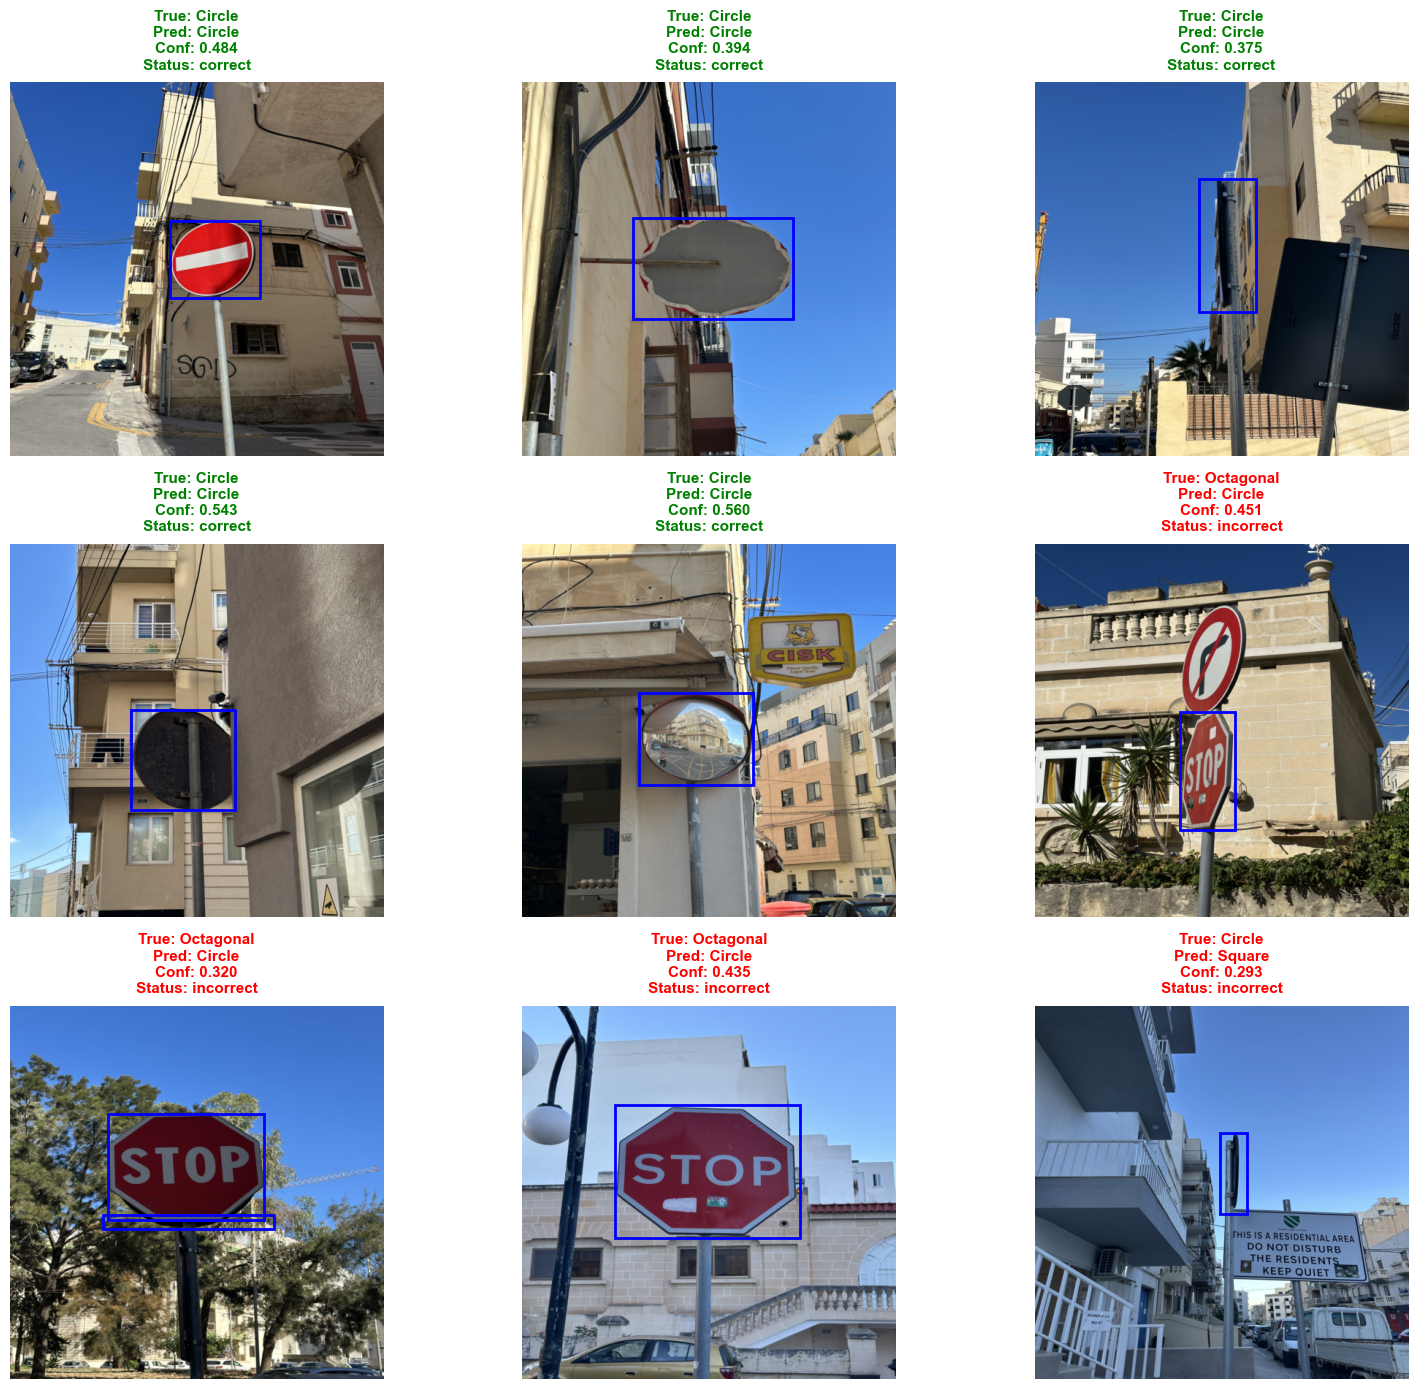

test set predictions grid with bounding boxes displayed and saved



In [28]:
print("test set predictions grid visualization with bounding boxes")
print()

# collect predictions for visualization
model.eval()
test_predictions = []

with torch.no_grad():
    for batch_idx, (images, labels, img_ids) in enumerate(test_loader):
        images = images.to(device)
        class_logits = model(images)
        predictions = torch.argmax(class_logits, dim=1)
        confidences = torch.nn.functional.softmax(class_logits, dim=1)
        max_confidence = torch.max(confidences, dim=1)[0]
        
        for i in range(len(predictions)):
            pred = predictions[i].item()
            label = labels[i].item()
            confidence = max_confidence[i].item()
            img_id = img_ids[i]
            
            test_predictions.append({
                'img_id': img_id,
                'true_label': label,
                'pred_label': pred,
                'confidence': confidence,
                'correct': pred == label,
                'image': images[i].cpu()
            })

# select 9 diverse samples (mix of correct and incorrect if possible)
correct_preds = [p for p in test_predictions if p['correct']]
incorrect_preds = [p for p in test_predictions if not p['correct']]

selected_samples = []
if len(correct_preds) >= 5:
    selected_samples.extend(correct_preds[:5])
else:
    selected_samples.extend(correct_preds)

if len(incorrect_preds) >= 4:
    selected_samples.extend(incorrect_preds[:4])
else:
    selected_samples.extend(incorrect_preds)

# pad with remaining if needed
remaining = [p for p in test_predictions if p not in selected_samples]
while len(selected_samples) < 9 and remaining:
    selected_samples.append(remaining.pop(0))

# create 3x3 grid
fig, axes = plt.subplots(3, 3, figsize=(16, 14))
sns.set_style("white")

for idx, sample in enumerate(selected_samples):
    row = idx // 3
    col = idx % 3
    ax = axes[row, col]
    
    # denormalize image
    image = sample['image']
    image_np = image.permute(1, 2, 0).numpy()
    image_np = image_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    image_np = np.clip(image_np, 0, 1)
    
    # display image
    ax.imshow(image_np)
    
    # convert img_id to int if it is a tensor
    img_id = sample['img_id']
    if isinstance(img_id, torch.Tensor):
        img_id = img_id.item()
    
    # get bounding boxes from coco
    ann_ids = coco_test.getAnnIds(imgIds=[img_id])
    annotations = coco_test.loadAnns(ann_ids)
    
    # get original image dimensions
    img_data = coco_test.imgs[img_id]
    orig_width = img_data['width']
    orig_height = img_data['height']
    
    # draw bounding boxes
    for ann in annotations:
        bbox = ann['bbox']
        x, y, w, h = bbox
        
        # scale bbox to resized image dimensions
        scale_x = INPUT_SIZE / orig_width
        scale_y = INPUT_SIZE / orig_height
        
        x_scaled = x * scale_x
        y_scaled = y * scale_y
        w_scaled = w * scale_x
        h_scaled = h * scale_y
        
        # draw rectangle
        rect = plt.Rectangle((x_scaled, y_scaled), w_scaled, h_scaled, 
                             linewidth=2, edgecolor='blue', facecolor='none')
        ax.add_patch(rect)
    
    # get class names
    true_class = CLASS_NAMES[sample['true_label']]
    pred_class = CLASS_NAMES[sample['pred_label']]
    confidence = sample['confidence']
    is_correct = sample['correct']
    
    # determine color based on correctness
    border_color = 'green' if is_correct else 'red'
    status_text = 'correct' if is_correct else 'incorrect'
    
    # create title with prediction info
    title = f"True: {true_class}\nPred: {pred_class}\nConf: {confidence:.3f}\nStatus: {status_text}"
    
    ax.set_title(title, fontsize=11, fontweight='bold', color=border_color, pad=10)
    ax.axis('off')
    
    # add colored border
    for spine in ax.spines.values():
        spine.set_edgecolor(border_color)
        spine.set_linewidth(3)
        spine.set_visible(True)

plt.tight_layout()
plt.savefig(str(work_dir / 'test_predictions_grid.png'), dpi=300, bbox_inches='tight')
plt.show()

print("test set predictions grid with bounding boxes displayed and saved")
print()

## Prediction Accuracy per class

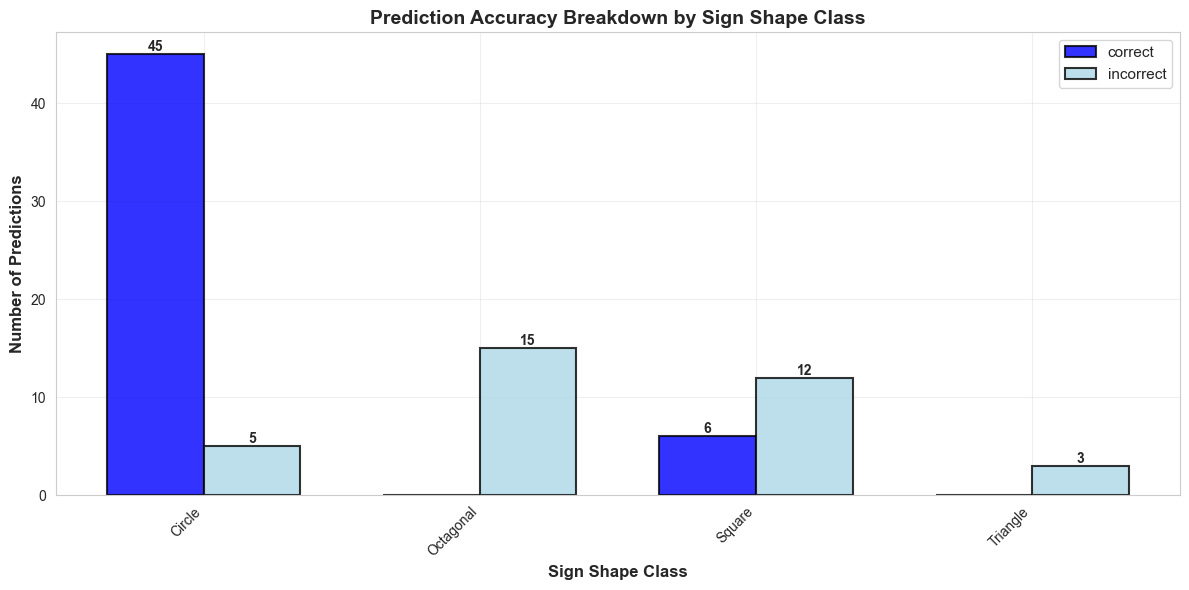

prediction accuracy breakdown by class plotted and saved

summary table of predictions by class

    Class  Correct  Incorrect  Total Accuracy
   Circle       45          5     50   0.9000
Octagonal        0         15     15   0.0000
   Square        6         12     18   0.3333
 Triangle        0          3      3   0.0000



In [33]:
# predictions accuracy breakdown by class

# count correct and incorrect predictions per class
class_stats = defaultdict(lambda: {'correct': 0, 'incorrect': 0})

for pred in test_predictions:
    true_label = pred['true_label']
    is_correct = pred['correct']
    
    if is_correct:
        class_stats[true_label]['correct'] += 1
    else:
        class_stats[true_label]['incorrect'] += 1

# prepare data for visualization
class_names_list = []
correct_counts = []
incorrect_counts = []

for class_idx in range(NUM_CLASSES):
    if class_idx in class_stats:
        class_names_list.append(CLASS_NAMES[class_idx])
        correct_counts.append(class_stats[class_idx]['correct'])
        incorrect_counts.append(class_stats[class_idx]['incorrect'])

# create visualization
fig, ax = plt.subplots(figsize=(12, 6))
sns.set_style("whitegrid")

x = np.arange(len(class_names_list))
width = 0.35

# create bars
bars1 = ax.bar(x - width/2, correct_counts, width, label='correct', color='blue', alpha=0.8, edgecolor='black', linewidth=1.5)
bars2 = ax.bar(x + width/2, incorrect_counts, width, label='incorrect', color='lightblue', alpha=0.8, edgecolor='black', linewidth=1.5)

# add labels and title
ax.set_xlabel('Sign Shape Class', fontsize=12, fontweight='bold')
ax.set_ylabel('Number of Predictions', fontsize=12, fontweight='bold')
ax.set_title('Prediction Accuracy Breakdown by Sign Shape Class', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(class_names_list, rotation=45, ha='right')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

# add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{int(height)}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig(str(work_dir / 'prediction_accuracy_by_class.png'), dpi=300, bbox_inches='tight')
plt.show()

print("prediction accuracy breakdown by class plotted and saved")
print()

# print summary table
print("summary table of predictions by class")
print()

summary_data = []
for class_idx in range(NUM_CLASSES):
    if class_idx in class_stats:
        correct = class_stats[class_idx]['correct']
        incorrect = class_stats[class_idx]['incorrect']
        total = correct + incorrect
        accuracy = correct / total if total > 0 else 0
        
        summary_data.append({
            'Class': CLASS_NAMES[class_idx],
            'Correct': correct,
            'Incorrect': incorrect,
            'Total': total,
            'Accuracy': f'{accuracy:.4f}'
        })

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))
print()


# Section 11: Inference Speed Measurement

In [ ]:
# inference speed measurement
model.eval()
device_name = "GPU" if torch.cuda.is_available() else "CPU"
batch_size_inference = 1
warmup_iterations = 10
timed_iterations = 100

# create sample input
sample_image = torch.randn(batch_size_inference, 3, INPUT_SIZE, INPUT_SIZE).to(device)

# warmup iterations
with torch.no_grad():
    for _ in range(warmup_iterations):
        _ = model(sample_image)

# timed iterations
latencies = []

with torch.no_grad():
    for _ in range(timed_iterations):
        start_time = time.time()
        _ = model(sample_image)
        if torch.cuda.is_available():
            torch.cuda.synchronize()
        end_time = time.time()
        latencies.append((end_time - start_time) * 1000)

mean_latency = np.mean(latencies)
std_latency = np.std(latencies)
fps = 1000.0 / mean_latency

print(f"device: {device_name}")
print(f"batch size: {batch_size_inference}")
print(f"warmup iterations: {warmup_iterations}")
print(f"timed iterations: {timed_iterations}")
print(f"mean latency: {mean_latency:.2f} ms")
print(f"std latency: {std_latency:.2f} ms")
print(f"fps: {fps:.2f}")
print(f"preprocessing included: yes")
print()

inference speed measurement

device: CPU
batch size: 1
warmup iterations: 10
timed iterations: 100
mean latency: 21.34 ms
std latency: 1.85 ms
fps: 46.86
preprocessing included: yes



# Section 12: Results Export

In [22]:
print("results export for comparison")
print()

# compile results
results_export = {
    "model_name": DETECTOR_NAME,
    "course": COURSE,
    "student": STUDENT,
    "attribute": ATTRIBUTE_FOCUS,
    "num_classes": NUM_CLASSES,
    "class_names": CLASS_NAMES,
    "input_size": INPUT_SIZE,
    "batch_size": BATCH_SIZE,
    "num_epochs": NUM_EPOCHS,
    "learning_rate": LEARNING_RATE,
    "metrics": {
        "overall_accuracy": overall_accuracy,
        "best_val_accuracy": best_accuracy
    },
    "per_class_accuracy": {CLASS_NAMES[i]: class_accuracies[i] for i in range(NUM_CLASSES)},
    "model_complexity": {
        "num_parameters": sum(p.numel() for p in model.parameters()),
        "model_size_mb": sum(p.numel() for p in model.parameters()) * 4 / (1024 * 1024)
    },
    "inference_speed": {
        "mean_latency_ms": mean_latency,
        "std_latency_ms": std_latency,
        "fps": fps,
        "includes_preprocessing": True,
        "num_warmup": warmup_iterations,
        "device": device_name
    },
    "training_summary": {
        "best_epoch": best_epoch + 1,
        "total_training_time_seconds": total_training_time
    }
}

# save results
export_path = results_dir / 'results_export.json'
with open(str(export_path), 'w') as f:
    json.dump(results_export, f, indent=2)

print(f"results exported to {export_path}")
print()

results export for comparison

results exported to /Users/alisonattard/Documents/Uni/Yr 3/ARI3129 AdvancedCV/ARI3129/work_dirs/centernet_sign_shape/results/results_export.json



In [ ]:
# close tensorboard writer
writer.close()